# IGBP Landcover classification

Open the high resolution dataset and extract the land flags that we need, then
reproject it to the windsat grid (Equal Degrees 0.25x0.25)


In [1]:
import xarray as xr
import numpy as np
import rasterio
import os

In [2]:
# Load a single windsat file to act as a template for the reprojection
windsat_folder = "../../data/raw/daily_windsat"
wsds = xr.open_dataset(
    os.path.join(windsat_folder, os.listdir(windsat_folder)[0]),
    decode_times = False
)
template = wsds[
    [
        "latitude",
        "longitude",
        "surtep_ERA5",
    ]
]

# Assing coordinates 
template = template.assign_coords(
    {
        "lat" : template.latitude,
        "lon" : template.longitude
    }
)

# roll the longitude 180º
template = template.roll(
    {
        "longitude_grid" : 4 * 180
    }
)

# Rename lat to y and lon to x
template = template.rename(
    {
        "lat": "y",
        "lon" : "x"
    }
)

# Manually add the crs
template.rio.write_crs("epsg:4326", inplace=True)
template = template.swap_dims(
    {
        "latitude_grid": "y",
        "longitude_grid" : "x"
    }
)

template = template.sel(swath_sector = 0)
template

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int32 4B 0
Data variables:
    latitude     (y) float32 3kB ...
    longitude    (x) float32 6kB 180.1 180.4 180.6 180.9 ... 179.4 179.6 179.9
    surtep_ERA5  (y, x) float32 4MB nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

# DATASET
https://lpdaac.usgs.gov/products/mcd12c1v006/

In [3]:
igbp_path = r"..\..\data\raw\MCD12C1.A2012001.051.2013178154403.hdf"
igpb_ds = xr.open_dataset(igbp_path, engine="netcdf4")

# Select the IGBP landcover classification dvar

desired_dv = "Majority_Land_Cover_Type_1"
igpb_ds = igpb_ds.drop_vars(
    dvar for dvar in igpb_ds.data_vars.keys() if dvar != desired_dv
)

igpb_ds


<xarray.Dataset> Size: 104MB
Dimensions:                     (YDim:MOD12C1: 3600, XDim:MOD12C1: 7200)
Dimensions without coordinates: YDim:MOD12C1, XDim:MOD12C1
Data variables:
    Majority_Land_Cover_Type_1  (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
Attributes:
    HDFEOSVersion:      HDFEOS_V2.9
    StructMetadata.0:   GROUP=SwathStructure\nEND_GROUP=SwathStructure\nGROUP...
    CoreMetadata.0:     \nGROUP                  = INVENTORYMETADATA\n  GROUP...
    ArchiveMetadata.0:  \nGROUP                  = ARCHIVEDMETADATA\n  GROUPT...

Sadly the product does not include the latitude and longitude coordinates, but we can generate them knowing the metadata and add them as coordinate vectors for latitude and longitude


In [11]:
gridSize = 0.05 #degrees
# We want the location of the center for each pixel
lat = np.arange(-90 + (gridSize / 2), 90 - (gridSize / 2) + gridSize, gridSize)
lon = np.arange(-180 + (gridSize / 2), 180 - (gridSize / 2) + gridSize, gridSize).tolist()

# Change lon origin to be 0 to 360
lon = [(l + 180) % 360 for l in lon]

# Add them as coordinates

igpb_ds = igpb_ds.assign_coords({
    "y" : ("YDim:MOD12C1",lat), 
    "x" : ("XDim:MOD12C1",lon),
})

# Reverse the latitude
igpb_ds = igpb_ds.isel(
    {
        "YDim:MOD12C1":slice(None, None, -1)
    }
)

igpb_ds.rio.write_crs("epsg:4326", inplace=True)
igpb_ds.attrs = {}
igpb_ds = igpb_ds.swap_dims({
    "YDim:MOD12C1" : "y",
    "XDim:MOD12C1" : "x"
})
igpb_ds

<xarray.Dataset> Size: 104MB
Dimensions:                     (y: 3600, x: 7200)
Coordinates:
  * y                           (y) float64 29kB 89.97 89.92 ... -89.92 -89.97
  * x                           (x) float64 58kB 0.025 0.075 ... 359.9 360.0
    spatial_ref                 int32 4B 0
Data variables:
    Majority_Land_Cover_Type_1  (y, x) float32 104MB 0.0 0.0 0.0 ... 12.0 12.0

In [12]:
igpb_ds.Majority_Land_Cover_Type_1

<xarray.DataArray 'Majority_Land_Cover_Type_1' (y: 3600, x: 7200)> Size: 104MB
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.]], dtype=float32)
Coordinates:
  * y            (y) float64 29kB 89.97 89.92 89.87 ... -89.88 -89.92 -89.97
  * x            (x) float64 58kB 0.025 0.075 0.125 0.175 ... 359.9 359.9 360.0
    spatial_ref  int32 4B 0
Attributes: (12/21)
    long_name:                           Majority_Land_Cover_Type_1
    units:                               class number
    valid_range:                         [ 0 16]
    water:                               0
    evergreen needleleaf forest:         1
    evergreen broadleaf forest:          2
    ...                                  ...
    croplands:                           12
    urban and built-up:                  13
    cropland/natural vegetation mosaic:  14
    snow and ice:                        15
    barren or sparsely vegetated:        16
    unclassified:                        255

In [13]:
template.surtep_ERA5

<xarray.DataArray 'surtep_ERA5' (y: 720, x: 1440)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int32 4B 0
Attributes:
    long_name:              ERA5 skin temperature
    standard_name:          surface_temperature
    units:                  Kelvin
    valid_min:              0.0
    coverage_content_type:  referenceInformation

---

Reproject using the mode for each cell of the windsat grid

In [14]:
igbp_wsgrid = igpb_ds.Majority_Land_Cover_Type_1.rio.reproject_match(template.surtep_ERA5,rasterio.enums.Resampling.mode)
igbp_wsgrid

<xarray.DataArray 'Majority_Land_Cover_Type_1' (y: 720, x: 1440)> Size: 4MB
array([[12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes: (12/21)
    long_name:                           Majority_Land_Cover_Type_1
    units:                               class number
    valid_range:                         [ 0 16]
    water:                               0
    evergreen needleleaf forest:         1
    evergreen broadleaf forest:          2
    ...                                  ...
    croplands:                           12
    urban and built-up:                  13
    cropland/natural vegetation mosaic:  14
    snow and ice:                        15
    barren or sparsely vegetated:        16
    unclassified:                        255

In [15]:
template["IGBP"] = igbp_wsgrid
template

<xarray.Dataset> Size: 8MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int32 4B 0
Data variables:
    latitude     (y) float32 3kB ...
    longitude    (x) float32 6kB 180.1 180.4 180.6 180.9 ... 179.4 179.6 179.9
    surtep_ERA5  (y, x) float32 4MB nan nan nan nan nan ... nan nan nan nan nan
    IGBP         (y, x) float32 4MB 12.0 12.0 12.0 12.0 12.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [16]:
# Save the file
save_path = os.path.join(r"..\\..\\data\processed\\", "regridded.h5")

igbp_wsgrid = template.drop_vars([
    dv for dv in template.data_vars if dv != "IGBP"
])

igbp_wsgrid.to_netcdf(save_path, engine="h5netcdf")

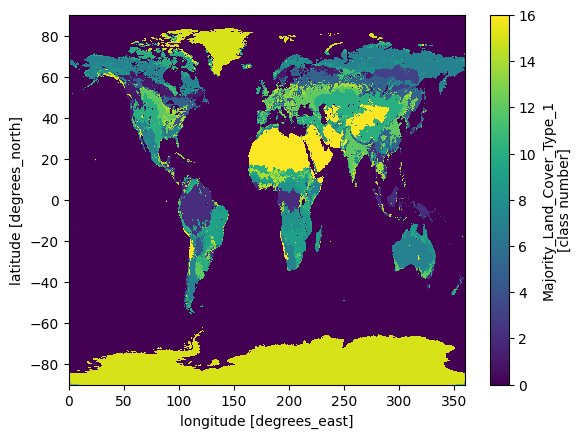

In [17]:
# Load the Landcover classification

xr.open_dataset(save_path).IGBP.plot()